# 3.6.3 Taylor et al 2023

This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

In [1]:
from importlib.resources import files
import dill

In [2]:
from optiwindnet.interarraylib import G_from_S
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.importer import L_from_yaml
from optiwindnet.pathfinding import PathFinder
from optiwindnet.MILP import solver_factory, ModelOptions
from optiwindnet.heuristics import EW_presolver
from optiwindnet.interarraylib import as_normalized

In [3]:
solver = solver_factory('gurobi')

## Reference solution

Taylor, P., Yue, H., Campos-Gaona, D., Anaya-Lara, O., & Jia, C. (2023). Wind farm array cable layout optimisation for complex offshore sites—A decomposition based heuristic approach. IET Renewable Power Generation, 17(2), 243–259. https://doi.org/10.1049/rpg2.12593

In [5]:
G_ref = dill.load(open('data/taylor_2023_paper_routeset.dill', 'rb'))

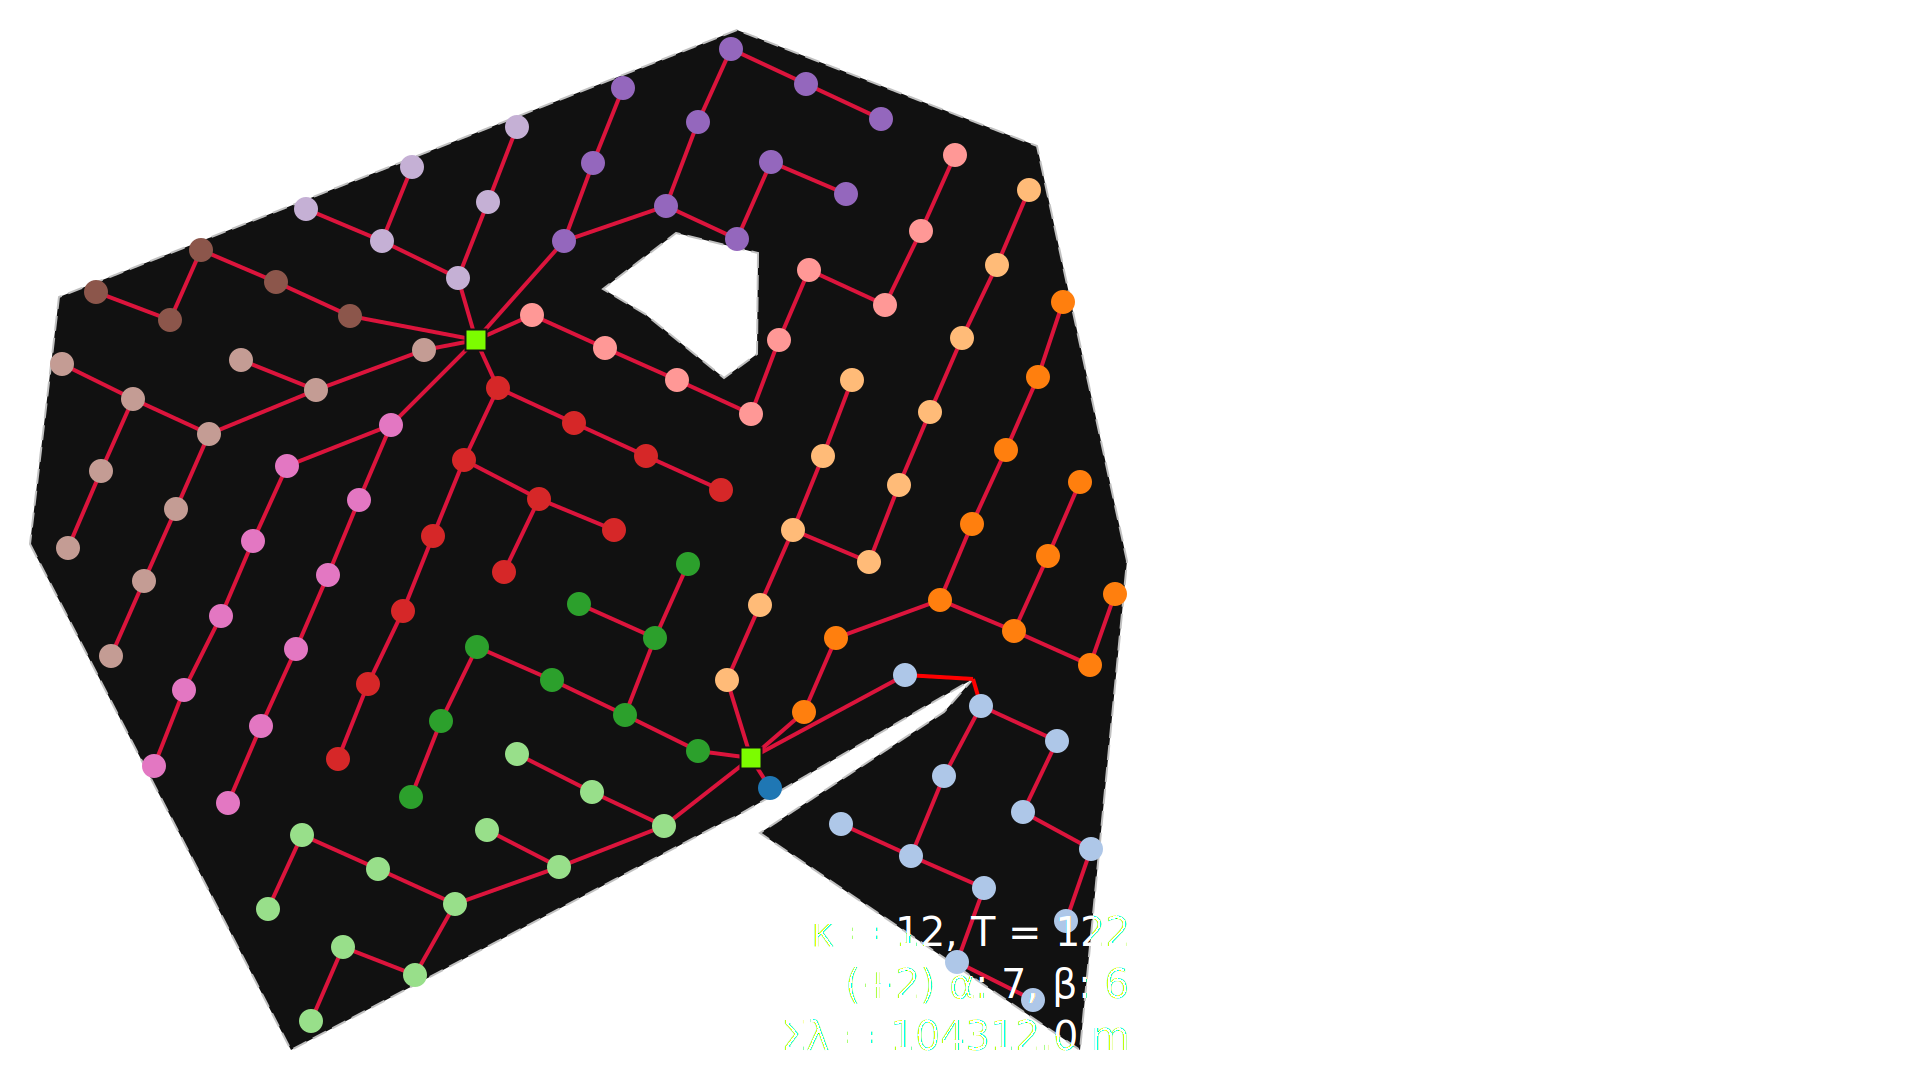

In [6]:
svgplot(G_ref)

## Start here

In [7]:
L = L_from_yaml(files('optiwindnet.data') / 'Taylor-2023.yaml')

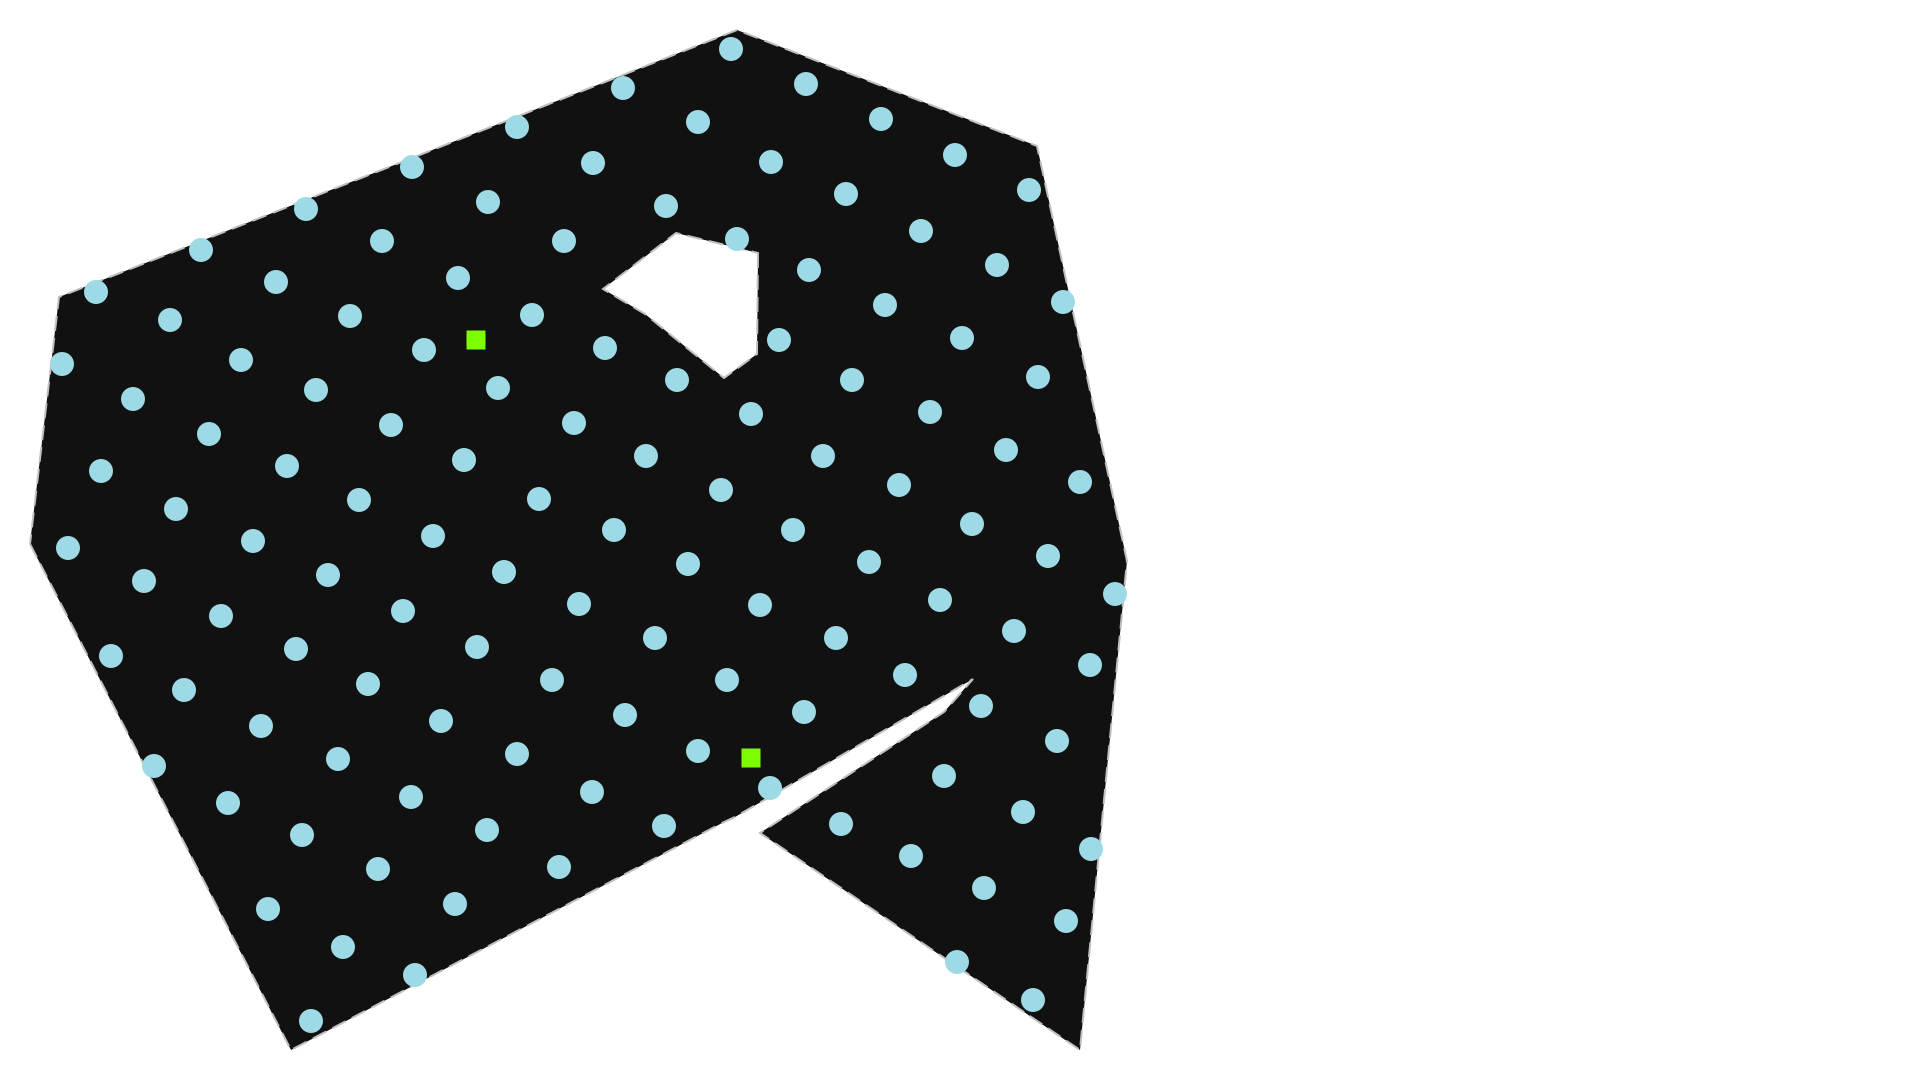

In [8]:
svgplot(L)

In [9]:
P, A = make_planar_embedding(L)

In [10]:
Sʹ = EW_presolver(A, 12)

In [11]:
Gʹ = G_from_S(Sʹ, A)

In [12]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

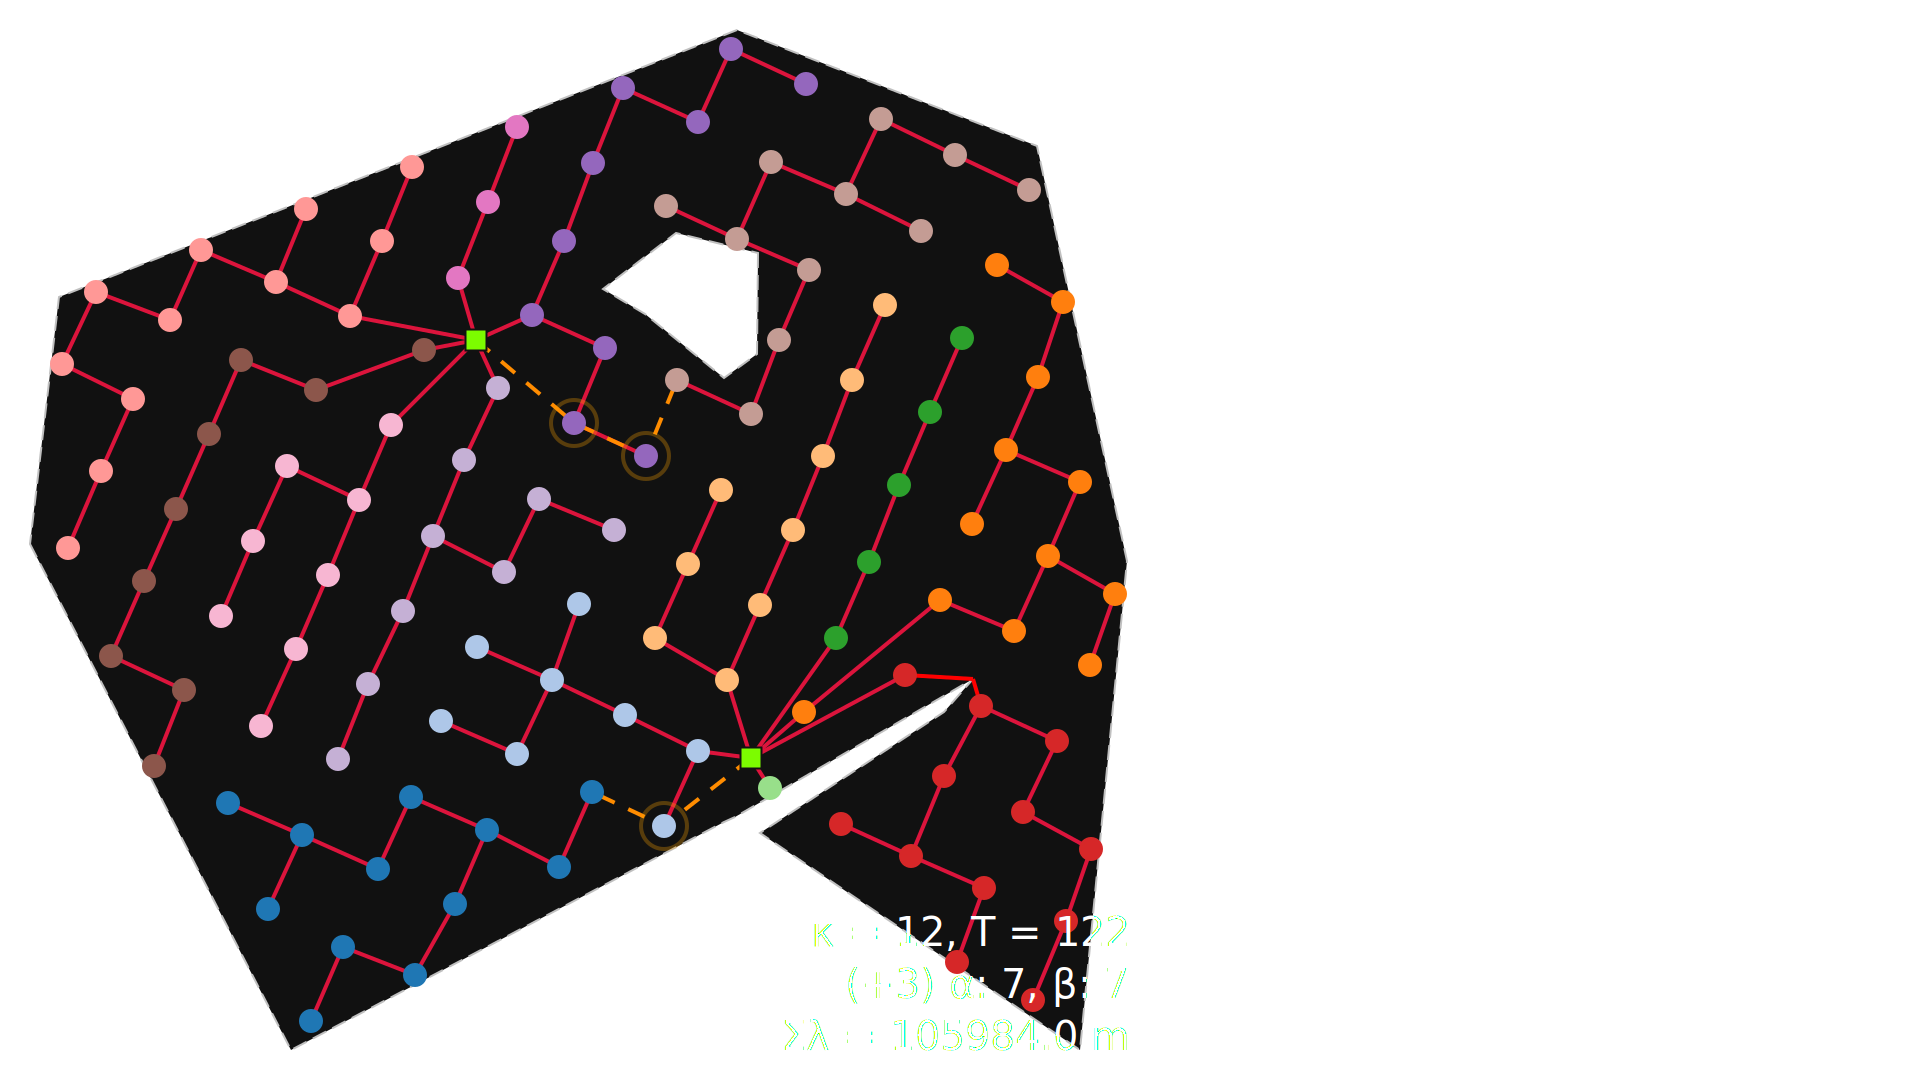

In [13]:
svgplot(Hʹ)

In [33]:
Sʹ = hgs_multiroot(as_normalized(A), capacity=12, time_limit=0.6)

In [34]:
Sʹ.graph['solution_time']

(0.21, 0.6)

In [35]:
Gʹ = G_from_S(Sʹ, A)

In [36]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

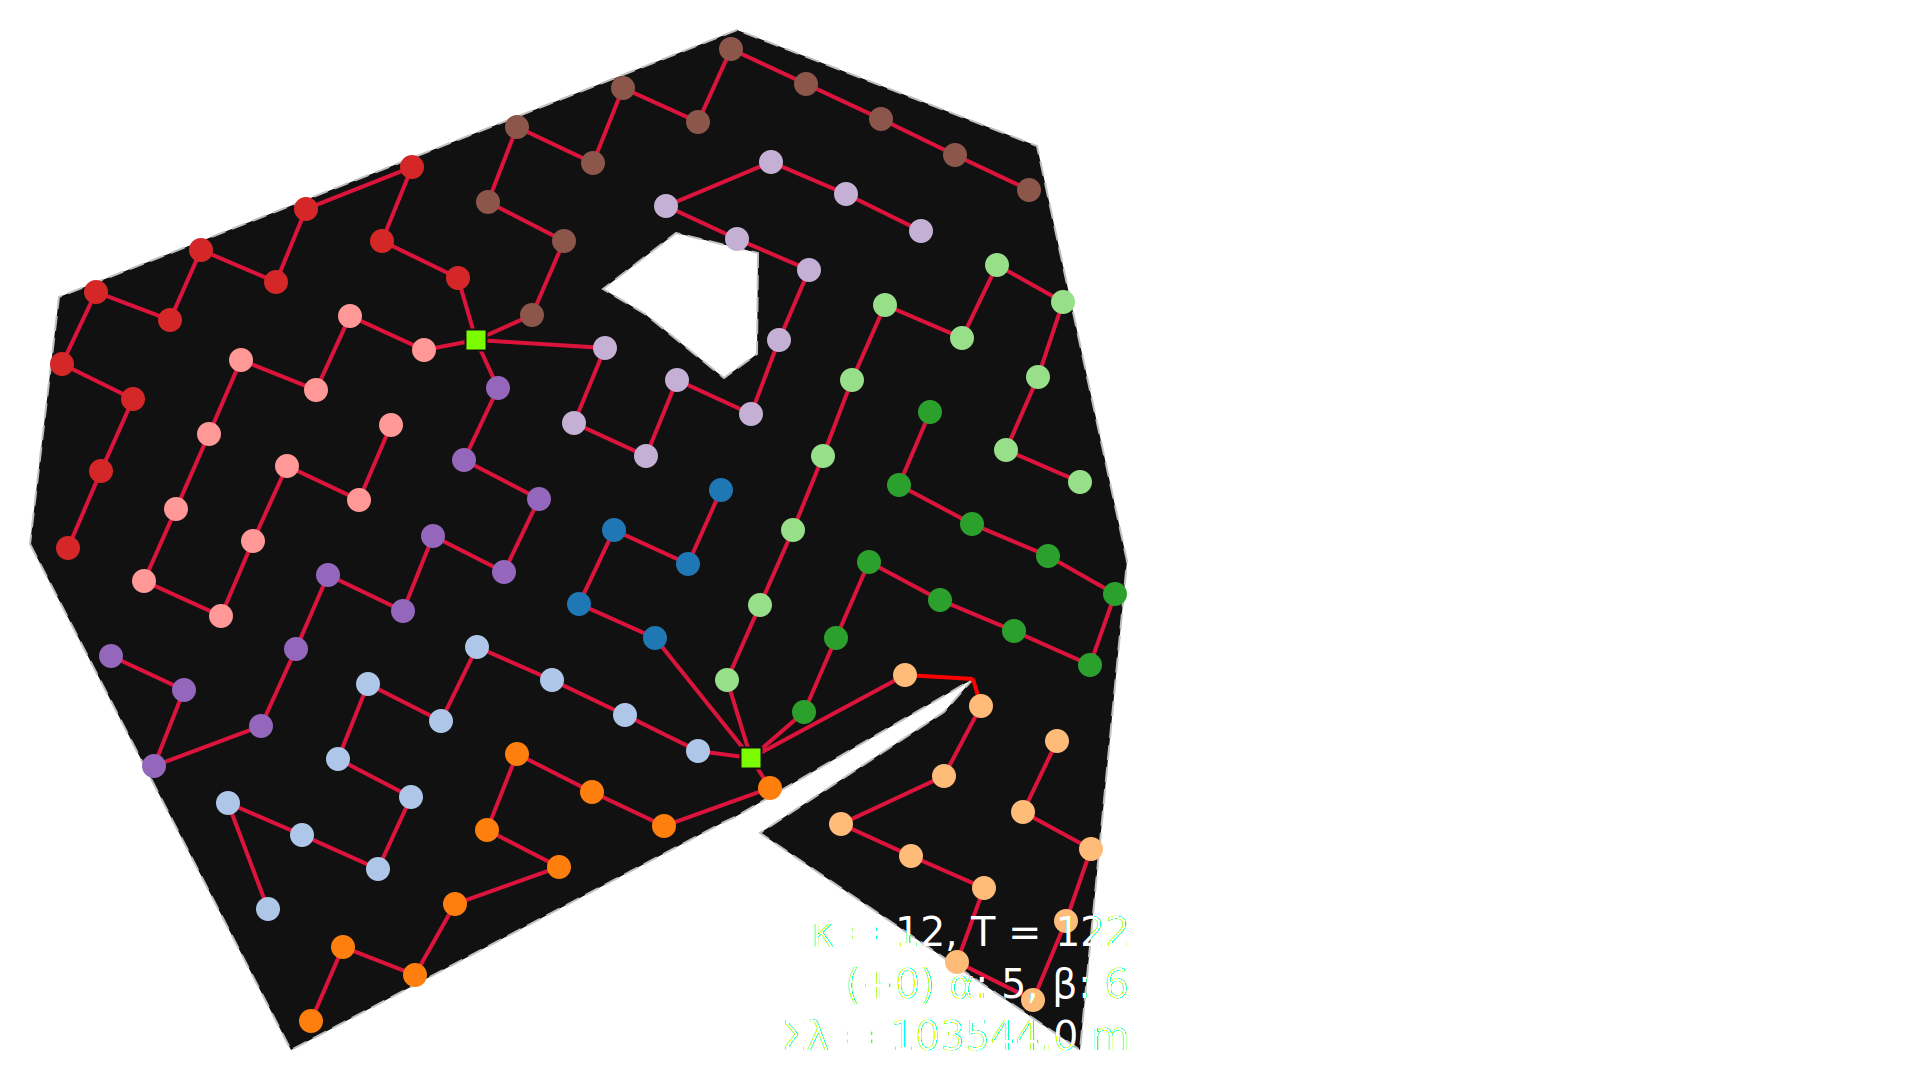

In [37]:
svgplot(Hʹ)

In [38]:
1 - Hʹ.size(weight='length')/G_ref.size(weight='length')

0.007366473452870892

In [41]:
solver.set_problem(
    P, A,
    capacity=Sʹ.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=Sʹ,
)

In [42]:
solver.solve(
    mip_gap=0.001,
    time_limit=8,
    verbose=True,
    options=dict(
        mipfocus=1,
        RINS=100,
        CutPasses=4,
        # VarBranch=1,
    )
)

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  8
MIPGap  0.001
MIPFocus  1
RINS  100
CutPasses  4

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4322 rows, 2896 columns and 16328 nonzeros
Model fingerprint: 0x6806bfea
Variable types: 0 continuous, 2896 integer (1448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+02, 9e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 103544

Presolve removed 531 rows and 0 columns
Presolve time: 0.03s
Presolved: 3791 rows, 2896 columns, 13820 nonzeros
Variable types: 0 continuous, 2896 integer (1448 binary)

Root r

SolutionInfo(runtime=8.032000064849854, bound=100573.80000832163, objective=100778.04543446109, relgap=0.0020266857256354687, termination='maxTimeLimit')

In [43]:
S, G = solver.get_solution()

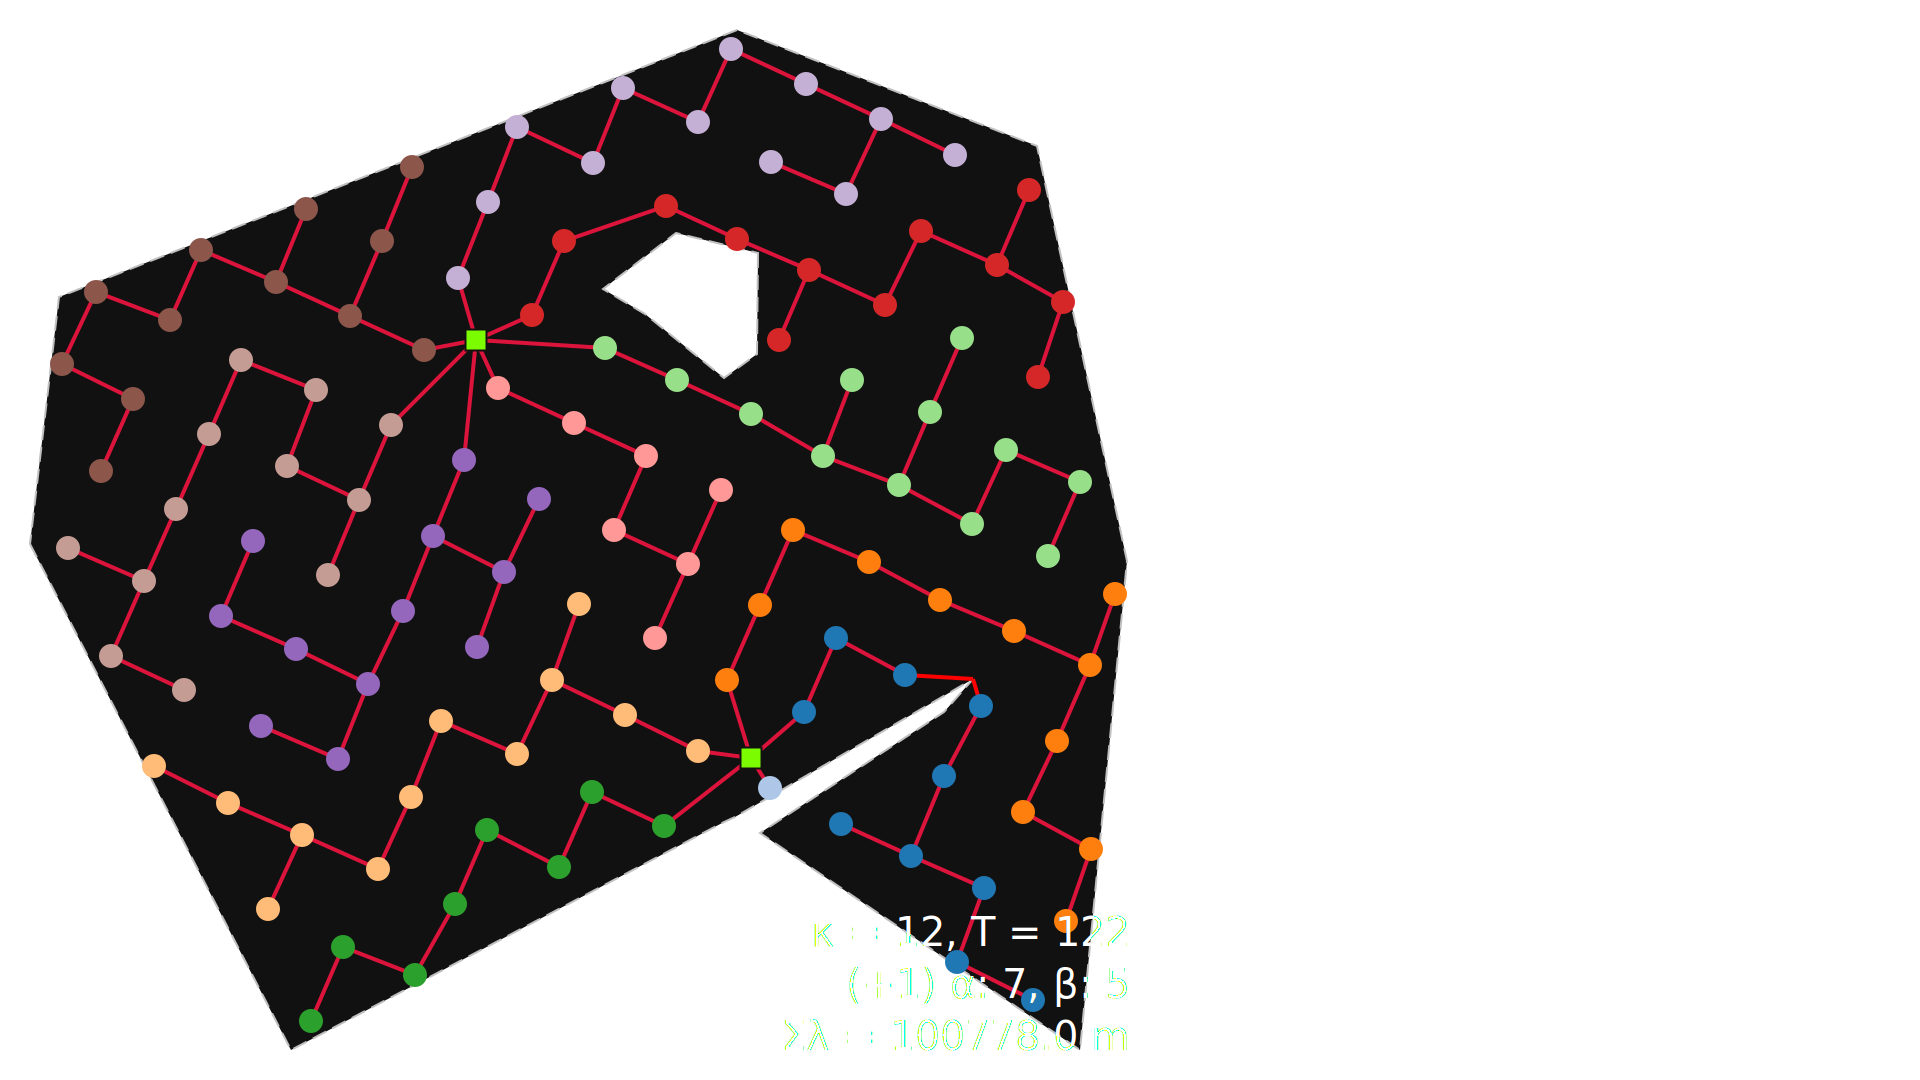

In [44]:
svgplot(G)

In [46]:
1 - G.size(weight='length')/G_ref.size(weight='length')

0.033879957250474324

In [48]:
with open('Taylor_comparison_κ_12_branched_our.dill', 'wb') as outfile:
    dill.dump(G, outfile)